# **Multi-objective knapsack problem**

***multiobj_knapsack.ipynb***

This example addresses a multi-objective knapsack problem, where the goal is to select a subset of items to maximize multiple value metrics, subject to a weight constraint. A blended (weighted-sum) and a lexicographic approach are applied to generate solutions using the Xpress multi-objective optimization capabilities for two objectives.

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the necessary packages
%pip install -q xpress matplotlib

### Problem description and model implementation

The knapsack problem involves selecting a subset of items, each with a weight and value, to maximize value without exceeding a weight limit. This model addresses a **multi-objective binary knapsack problem**, where the goal is to select a subset of items to maximize over different value metrics, subject to the weight constraint. In this example, we work with two objectives for simplicity, but three or more objectives could be defined as well.

The problem has the following data:
- A set of $n = 15$ items to choose from.
- Each item $i \in \{1, 2, \dots, n\}$ has:
  - A weight $w_i \in \{1, \dots , 20\}$
  - Two value metrics $v_{i1}, v_{i2} \in \{1, \dots, 20\}$
- The total weight of selected items must not exceed a maximum capacity $W = 50$.

Let $x_i \in \{0, 1\}$ be a binary decision variable indicating whether item $i$ is selected (=1) or not (=0), subject to the constraint:
$$
\sum_{i=1}^{n} w_i x_i \leq W
$$

This **multi-objective optimization** problem has two objectives:

1. Maximize total value according to metric 1:
   $$
   \text{Objective 1: } \max \sum_{i=1}^{n} v_{i1} x_i
   $$

2. Maximize total value according to metric 2:
   $$
   \text{Objective 2: } \max \sum_{i=1}^{n} v_{i2} x_i
   $$

These objectives can be handled in different ways:
- **Blended (weighted-sum) approach**: Combine both objectives using a weight parameter $\lambda \in [0, 1]$:
  $$
  \max \left( \lambda \sum_{i=1}^{n} v_{i1} x_i + (1 - \lambda) \sum_{i=1}^{n} v_{i2} x_i \right)
  $$

- **Lexicographic approach**: Prioritize one objective over the other, solving for the most important one first, adding a constraint enforcing that value to remain (possibly within a given tolerance), and solve again for the second objective.

The code cell below imports the necessary libraries, defines the data, creates a new problem, and adds the set of binary variables and the capacity constraint (using the [xpress.Dot](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/xpress.Dot.html) operator). The solver logs are then turned off by setting the `outputlog` control to zero for cleaner outputs.

In [ ]:
import xpress as xp
import numpy as np
from matplotlib import pyplot as plt

n = 15            # Number of items
max_weight = 50   # Maximum weight that can be carried

# Random weights and two random value metrics.
np.random.seed(123)
item_weights = np.random.randint(1, 21, n)
item_values = np.random.randint(1, 21, (2, n)) # Two arrays of value metrics

p = xp.problem()

# Decision variables for each item.
take = p.addVariables(n, vartype=xp.binary)

# Total weight cannot exceed maximum weight.
ctr = xp.Dot(take, item_weights) <= max_weight

p.addConstraint(ctr)

p.controls.outputlog = 0  # Suppress solver output

### Blended approach

This section explores the Pareto frontier for the knapsack problem by varying the objective weights, with the first objective having a `weight` ranging from 0 up to 1, in steps of 0.05, with the weight for the second objective being the complement of the first objective. 

When setting objectives using [problem.setObjective](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.setObjective.html) or adding new objectives using [problem.addObjective](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addObjective.html), if **objectives have equal priority but different weights, a Blended (or Archimedian) approach is applied**, that is, the objective function of the problem is the linear combination of the value of the selected objects with their respective objective weights. The `sense` argument of the first added objective defines the sense of the problem, that is, it applies for all objectives.

A loop allows iterating through each of the 20 weight distribution cases. We optimize and **save the two objective values for each case using the [problem.calcojbn](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.calcObjN.html)** method. The tradeoff between objective values are then plotted using the Matplotlib module.

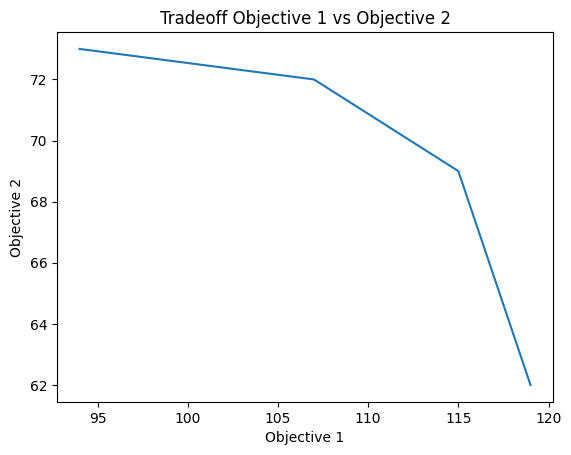

In [ ]:
# Vary the objective weights to explore the optimal frontier
obj1_weights = np.arange(0, 1, 0.05)
obj1 = []
obj2 = []

for w in obj1_weights:
  # First objective defines the sense of the optimization for all objectives
  p.setObjective(xp.Dot(take, item_values[0]), objidx=0, weight=w, sense=xp.maximize)
  # Second objective with complementary weight
  p.setObjective(xp.Dot(take, item_values[1]), objidx=1, weight=1-w)
  p.optimize()
  sol = p.getSolution(take)
  obj1.append(p.calcObjN(0))
  obj2.append(p.calcObjN(1))

plt.plot(obj1, obj2)
plt.title('Tradeoff Objective 1 vs Objective 2')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.show()

### Lexicographic approach

We now switch to a **lexicographic optimization** approach, where the first objective is given higher priority than the second. When **objectives have a different priority but the same weight, a Lexicographic approach is applied**. Xpress will solve the problem once for each distinct objective priority that is defined. All objectives from previous iterations are fixed to their optimal values (within the absolute and relative tolerances defined by the *abstol* and *reltol* arguments, respectively). 

The code cell below sets a higher `priority` for the first objective, giving a tolerance of 5% between the optimal value from the first to the second run by setting `reltol` to 0.05.

If both runs are successful in generating a solution, the script prints the selected items, the total weight, and the values of both objectives. This approach ensures that the most important objective is optimized first, and the second is optimized only within a solution space close to the optimal solution(s) for the first.

In [ ]:
# Define the two objectives with priorities for lexicographic approach
p.setObjective(xp.Dot(take, item_values[0]), objidx=0, priority=2, reltol=0.05, sense=xp.maximize)
p.setObjective(xp.Dot(take, item_values[1]), objidx=1, priority=1)

# Solve the problem
p.optimize()

if p.attributes.solvestatus == xp.SolveStatus.COMPLETED and p.attributes.solstatus == xp.SolStatus.OPTIMAL:
  print('Problem was solved to optimality')
  sol = p.getSolution(take)
  print('Items selected:', ', '.join(str(i) for i in range(n) if sol[i]))
  print('Total weight:', xp.Dot(sol, item_weights))
  print('First objective:', p.calcObjN(0))
  print('Second objective:', p.calcObjN(1))
elif p.attributes.solvedobjs == 1:
  print('Solved first objective but failed to solve second objective')
else:
  print('Failed to solve first objective')

Problem was solved to optimality
Items selected: 0, 1, 2, 6, 7, 12, 13, 14
Total weight: 50.0
First objective: 115.0
Second objective: 69.0


By running the code cell below, we can observe that the final solution from the lexicographic method (red dot) lies on the efficient frontier previously generated.

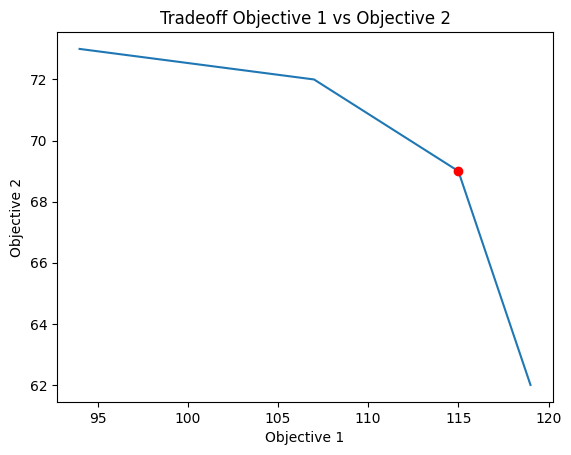

In [44]:
# Plot the lexicographic solution on the efficient frontier
plt.plot(obj1, obj2)
plt.plot(p.calcObjN(0), p.calcObjN(1), c='r', marker='o')
plt.title('Tradeoff Objective 1 vs Objective 2')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.show()